# SetUp

In [19]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':22})
import datetime
from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn import metrics
rs = RandomState(MT19937(SeedSequence(123456789)))

In [10]:
# Define simulate ride data function

def simulate_ride_data():
    ride_dists = np.concatenate((
        10*np.random.random(size = 370),
        30*np.random.random(size = 10),
        10*np.random.random(size = 10),
        10*np.random.random(size = 10)
    ))
    ride_speeds = np.concatenate((
        np.random.normal(loc = 30, scale = 5, size = 370),
        np.random.normal(loc = 30, scale = 5, size = 10),
        np.random.normal(loc = 50, scale = 10, size = 10),
        np.random.normal(loc = 15, scale = 4, size = 10)
    ))
    ride_times = ride_dists/ride_speeds
    
    df = pd.DataFrame(
        {
            'ride_dist': ride_dists, 
            'ride_time': ride_times,  
            'ride_speed': ride_speeds
        }
    )
    ride_ids = datetime.datetime.now().strftime('%Y%m%d') + df.index.astype(str)
    df['ride_id'] = ride_ids
    
    return df

# The Data

In [12]:
file_path = 'Chapter01\batch-anomaly\data\taxi-rides.csv'
if os.path.exists(file_path):
    df = pd.read_csv(file_path)

<Axes: >

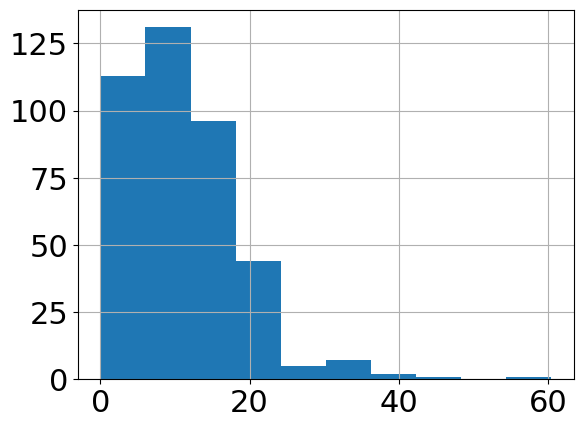

In [14]:
(df['ride_time']*60).hist()

<Axes: >

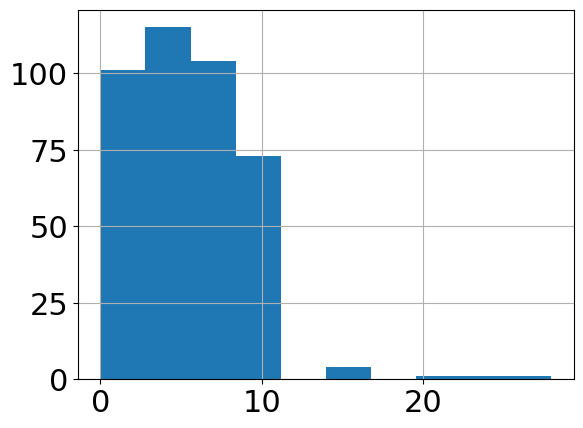

In [15]:
df['ride_dist'].hist()

<Axes: >

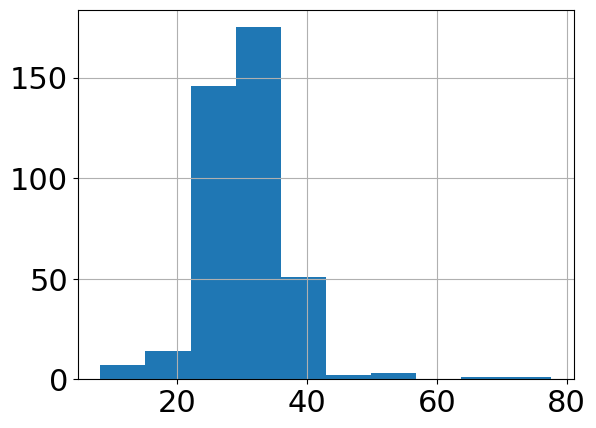

In [16]:
df['ride_speed'].hist()

<Axes: xlabel='ride_dist', ylabel='ride_time'>

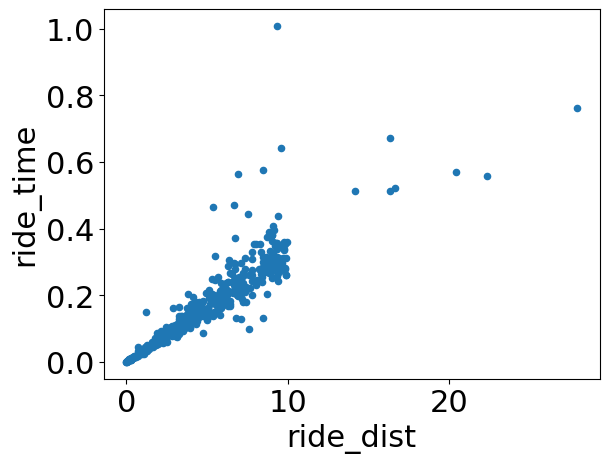

In [17]:
df.plot(x='ride_dist', y = 'ride_time', kind = 'scatter')

In [18]:
df.head()

,ride_dist,ride_time,ride_speed,ride_id
0,0.830471,0.036832,22.547764,202302210
1,5.403242,0.150252,35.961096,202302211
2,3.023363,0.078073,38.724948,202302212
3,1.088474,0.028781,37.818669,202302213
4,3.204744,0.100034,32.036670,202302214


# Clustering with DBSCAN

In [45]:
def cluster_and_label(X, create_and_show_plot=True):
    X = StandardScaler().fit_transform(X)
    db = DBSCAN(eps=0.3, min_samples=10).fit(X)

    # Find labels from the clustering
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    #print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
    #print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
    #print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
    #print("Adjusted Rand Index: %0.3f"
    #      % metrics.adjusted_rand_score(labels_true, labels))
    #print("Adjusted Mutual Information: %0.3f"
    #      % metrics.adjusted_mutual_info_score(labels_true, labels))
    print("Silhouette Coefficient: %0.3f"
          % metrics.silhouette_score(X, labels))

    run_metadata = {
        'nClusters': n_clusters_,
        'nNoise': n_noise_,
        'silhouetteCoefficient': metrics.silhouette_score(X, labels),
        'labels': labels,
    }
    if create_and_show_plot == True:
        fig = plt.figure(figsize=(10,10))
        # Black removed and is used for noise instead.
        unique_labels = set(labels)
        colors = [plt.cm.cool(each)
                  for each in np.linspace(0, 1, len(unique_labels))]
        for k, col in zip(unique_labels, colors):
            if k == -1:
                # Black used for noise.
                col = [0, 0, 0, 1]
            class_member_mask = (labels== k)
            xy = X[class_member_mask & core_samples_mask]
            plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                     markeredgecolor='k', markersize=14)
            xy = X[class_member_mask & ~core_samples_mask]
            plt.plot(xy[:, 0], xy[:, 1], '^', markerfacecolor=tuple(col),
                     markeredgecolor='k', markersize=14)
            
        plt.xlabel('Standard Scaled Ride Dist.')
        plt.ylabel('Standard Scaled Ride Time')
        plt.title('Estimated number of clusters: %d' % n_clusters_)
        plt.show()
    else:
        pass
    return run_metadata

Estimated number of clusters: 1
Estimated number of noise points: 21
Silhouette Coefficient: 0.553


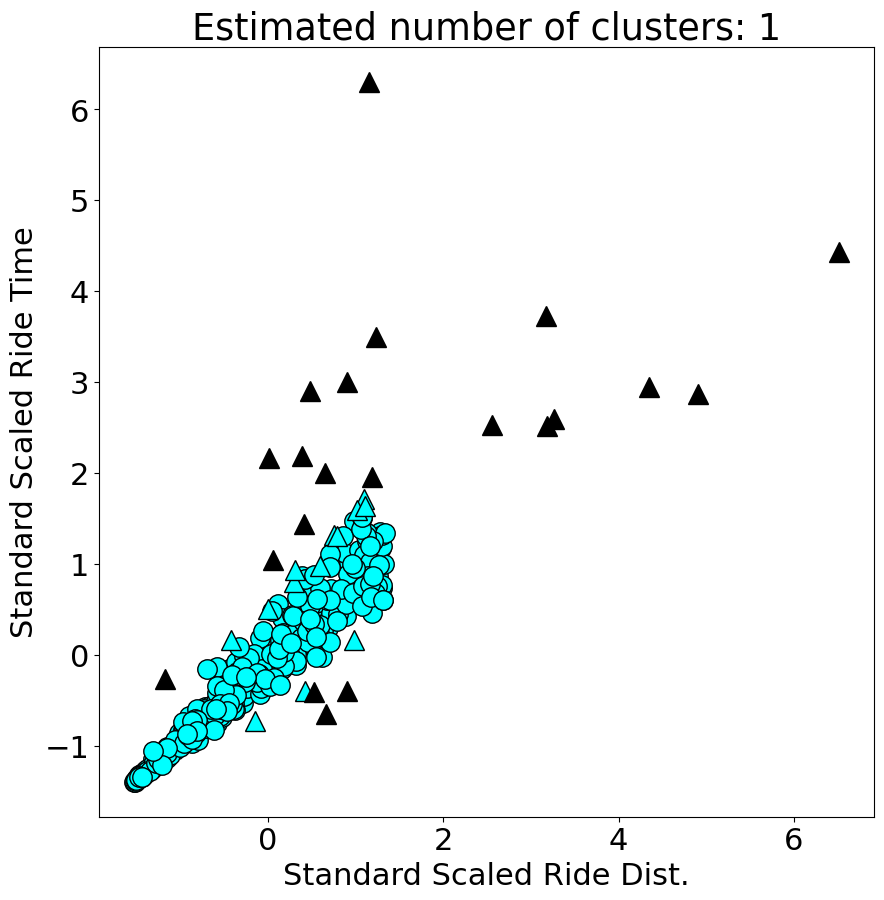

In [46]:
# Create plots
X = df[['ride_dist', 'ride_time']]
results = cluster_and_label(X)
df['label'] = results['labels']

In [41]:
df.to_json('../output/labels.json', orient = 'records')

In [42]:
df[df['label'] == 1].to_json(orient='records')

'[]'